In [1]:
pacman::p_load(tidyverse, sigfit, readxl, vcfR, VariantAnnotation, rtracklayer, Biostrings, Rsamtools, patchwork)


Installing package into ‘/n/data1/bch/genetics/lee/eam63/tools/R-4.2.1/library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘sigfit’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in p_install(package, character.only = TRUE, ...):
“”
Warning message in library(package, lib.loc = lib.loc, character.only = TRUE, logical.return = TRUE, :
“there is no package called ‘sigfit’”
Warning message in pacman::p_load(tidyverse, sigfit, readxl, vcfR, VariantAnnotation, :
“Failed to install/load:
sigfit”


In [2]:

data_vaf = read_csv("../../data/annotated-calls_vaf.csv") %>% 
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data = read_csv("../../data/annotated-calls.csv") %>%
    mutate(var_id = glue::glue("{`Individual ID`}-{CHROM}:{POS}-{Mutation}"))
data$AF = data_vaf$`VAF[reads, BSMN]`[match(data$var_id, data_vaf$var_id)]
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")
# 

## filter outlier
data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))



Rows: 3383 Columns: 28
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (11): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (15): POS, VAF[alleles, BSMN], BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCN...
num  (2): FORMAT/AD, FORMAT/PL

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Warning message:
“One or more parsing issues, call `problems()` on your data frame for details, e.g.:
  dat <- vroom(...)
  problems(dat)”
Rows: 6426 Columns: 137
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (47): Individual ID, CHROM, Mutation, REF, ALT, FILTER/PASS, culprit, Ch...
dbl (85): POS, AF, BaseQRankSum, DP, FS, SOR, VQSLOD, szdbCNVcount, GWASpval...
lgl  (5): targetscan_Reg

p_val,beta,se,n_muts,epi_mark
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.0015018843,0.50322234,0.15852922,143,DHS
0.0004286537,-0.32072415,0.09106867,360,H3K27me3
0.5534538864,0.20985906,0.35413720,408,H3K36me3
0.1643268126,0.13006659,0.09352829,501,H3K4me1
0.9449716834,0.01169346,0.16941505,147,H3K4me3
0.5906989228,0.26457637,0.49193904,413,H3K9me3


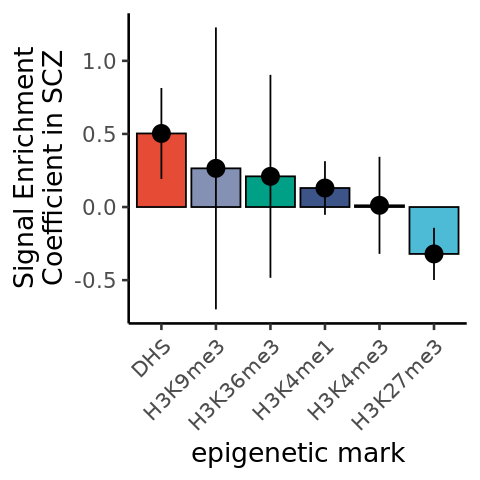

In [3]:
## DHS regression
## Plot results as barplots

epi_regression <-  function(v_scz,v_ctrl, epi_path){
    epimark = rtracklayer::import(epi_path)
    #epimark = GenomicRanges::intersect(epimark,mapped_gr,ignore.strand=TRUE)

    epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
    epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

    epimark$bin_length = width(epimark)

    plot_df = mcols(epimark) %>% as.data.frame()

    n_dx= 60
    n_ctrl = 25

    analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

    m0 = summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score+1), family=binomial(link="log"), data=analyze_df))
    c = coef(m0)
    return(c(p_val = c[4,4], beta = c[4,1], se=c[4,2], n_muts = sum(analyze_df$sSNV_burden)))
}

epi_list = c("../../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz",
             "../../resources/E081-H3K27me3.broadPeak.gz",
            "../../resources/E081-H3K36me3.broadPeak.gz",
            "../../resources/E081-H3K4me1.broadPeak.gz",
            "../../resources/E081-H3K4me3.broadPeak.gz",
            "../../resources/E081-H3K9me3.broadPeak.gz")

epi_res = lapply(epi_list, function(x){
    epi_regression(v_scz,v_ctrl, x)
})

library("ggsci")
options(repr.plot.width=4, repr.plot.height=4)
epi_df = do.call(rbind, epi_res) %>% as.data.frame() %>% mutate(epi_mark = c("DHS","H3K27me3","H3K36me3",
                                                                                  "H3K4me1","H3K4me3","H3K9me3"))
epi_df
p1= epi_df %>% ggplot(aes(x=reorder(epi_mark,-beta),y=beta)) + geom_bar(stat="identity", aes(fill = epi_mark), color="black", show.legend=FALSE) +
    scale_fill_npg() + theme_classic(16) + 
    geom_pointrange(aes(ymin = beta - 1.96*se, ymax=beta + 1.96*se), color="black",size=1) +
    theme(axis.text.x = element_text(angle = 45, vjust = 1,hjust=1)) +
    labs(x="epigenetic mark", y = "Signal Enrichment\nCoefficient in SCZ", fill = "")
p1

# ggsave(p1, filename = "../figures/epi_enrichment_no_outlier.pdf",device="pdf",width=4,height=4)

In [4]:
## Performing bootstrapping

B = 1000

epimark = rtracklayer::import( "../../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz")

epi_boot <-  function(v_scz,v_ctrl, epimark){

    epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
    epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

    epimark$bin_length = width(epimark)

    n_dx= 60
    n_ctrl = 25
    
    plot_df = mcols(epimark) %>% as.data.frame()

    analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

    m0 = summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score+1), family=binomial(link="log"), data=analyze_df))
    c = coef(m0)
    return(c(p_val = c[4,4], beta = c[4,1], se=c[4,2], n_muts = sum(analyze_df$sSNV_burden)))
}


res_boot = parallel::mclapply(1:B, function(x){
    dx_boot = sample(data$Dx,replace = FALSE)
    data_boot = data %>% mutate(dx_boot = dx_boot)
    v_scz_boot = make_vcf(data %>% filter(dx_boot=="SCZ"))
    v_ctrl_boot = make_vcf(data %>% filter(dx_boot != "SCZ"))
    return(epi_boot(v_scz_boot,v_ctrl_boot,epimark))
})




,p_val,beta,se,n_muts
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.7375202,0.05366553,0.1601291,143
2,0.6381161,-0.06768726,0.1439130,143
3,0.9595551,0.00747454,0.1473923,143
4,0.7035517,-0.05676702,0.1491786,143
5,0.2457991,0.17491953,0.1507130,143
6,0.1696026,-0.21167198,0.1541134,143


[1] 0

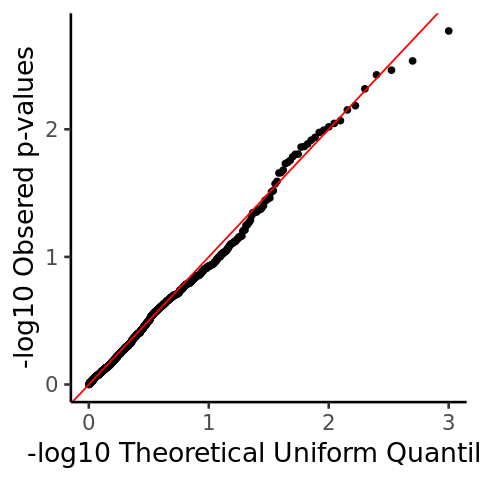

In [5]:
res = do.call(rbind, res_boot) %>% as.data.frame()
head(res)

2*sum(res$beta > epi_df$beta[1])/B

p1 = res %>% ggplot(aes(x= -log10(1:nrow(.)/(nrow(.)+1)), y=-log10(sort(p_val)))) +
    geom_point() +
    geom_abline(slope = 1,color="red") +
    theme_classic(16)+
    labs(x="-log10 Theoretical Uniform Quantiles",y="-log10 Obsered p-values") 

p1

ggsave("../../figures/qqplot_dhs.pdf",width=4,height=4)


,p_val,beta,se,n_muts
,<dbl>,<dbl>,<dbl>,<dbl>
1,0.3882926,-0.07986325,0.09257169,360
2,0.6859123,0.03819079,0.09443617,360
3,0.4834952,-0.06463796,0.09224874,360
4,0.3863752,-0.08206004,0.09473461,360
5,0.7650189,-0.02793495,0.09346022,360
6,0.1704799,0.13827925,0.10088491,360


[1] 0

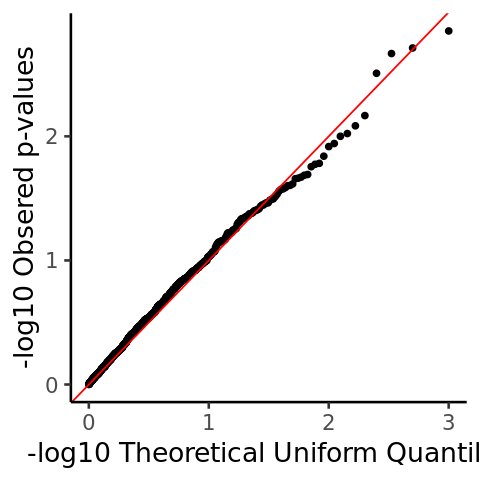

In [6]:
## Performing bootstrapping

B = 1000

epimark = rtracklayer::import( "../../resources/E081-H3K27me3.broadPeak.gz")

epi_boot <-  function(v_scz,v_ctrl, epimark){

    epimark$SCZ_sSNV = countOverlaps(epimark,v_scz)
    epimark$CONT_sSNV = countOverlaps(epimark, v_ctrl)

    epimark$bin_length = width(epimark)

    n_dx= 60
    n_ctrl = 25
    
    plot_df = mcols(epimark) %>% as.data.frame()

    analyze_df = plot_df %>% mutate(bin_length_scz = bin_length*n_dx, bin_length_ctrl = bin_length*n_ctrl) %>%
    pivot_longer(SCZ_sSNV:CONT_sSNV, names_to="Dx", values_to = "sSNV_burden")  %>% 
    mutate(bin_length0 = ifelse(Dx=="SCZ_sSNV", bin_length_scz, bin_length_ctrl))

    m0 = summary(glm(cbind(sSNV_burden, bin_length0 - sSNV_burden) ~ Dx*log(score+1), family=binomial(link="log"), data=analyze_df))
    c = coef(m0)
    return(c(p_val = c[4,4], beta = c[4,1], se=c[4,2], n_muts = sum(analyze_df$sSNV_burden)))
}


res_boot = parallel::mclapply(1:B, function(x){
    dx_boot = sample(data$Dx,replace = FALSE)
    data_boot = data %>% mutate(dx_boot = dx_boot)
    v_scz_boot = make_vcf(data %>% filter(dx_boot=="SCZ"))
    v_ctrl_boot = make_vcf(data %>% filter(dx_boot != "SCZ"))
    return(epi_boot(v_scz_boot,v_ctrl_boot,epimark))
})


res = do.call(rbind, res_boot) %>% as.data.frame()
head(res)

2*sum(res$beta > epi_df$beta[1])/B

p1 = res %>% ggplot(aes(x= -log10(1:nrow(.)/(nrow(.)+1)), y=-log10(sort(p_val)))) +
    geom_point() +
    geom_abline(slope = 1,color="red") +
    theme_classic(16)+
    labs(x="-log10 Theoretical Uniform Quantiles",y="-log10 Obsered p-values") 

p1

ggsave("../../figures/qqplot_h3k27me3.pdf",width=4,height=4)




Attaching package: ‘plyranges’


The following object is masked from ‘package:VariantAnnotation’:

    select


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:IRanges’:

    slice


The following objects are masked from ‘package:dplyr’:

    between, n, n_distinct


The following object is masked from ‘package:stats’:

    filter




[1] 138

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 111
ENSEMBL_MART_SNP,Ensembl Variation 111
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 111


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”
Loading required package: BSgenome

Loading required package: grid


Attaching package: ‘grid’


The following object is masked from ‘package:Biostrings’:

    pattern


Warning message:
“replacing previous import ‘Biostrings::pattern’ by ‘grid::pattern’ when loading ‘genomation’”



	Comparison of Poisson rates

data:  c(as.integer(scz_counts[bin_num%/%2 + 1L]), as.integer(ctrl_counts[bin_num%/%2 + 1L])) time base: c(n_dx * nrow(x$SCZ) * bin_size, n_ctrl * nrow(x$CONT) * bin_size)
count1 = 43, expected count1 = 35.488, p-value = 0.01875
alternative hypothesis: true rate ratio is not equal to 1
95 percent confidence interval:
 1.120366 6.618309
sample estimates:
rate ratio 
  2.511979 



Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”



	Comparison of Poisson rates

data:  c(as.integer(scz_counts[bin_num%/%2 + 1L]), as.integer(ctrl_counts[bin_num%/%2 + 1L])) time base: c(n_dx * nrow(x$SCZ) * bin_size, n_ctrl * nrow(x$CONT) * bin_size)
count1 = 23, expected count1 = 18.49, p-value = 0.05252
alternative hypothesis: true rate ratio is not equal to 1
95 percent confidence interval:
  0.9407672 16.1998138
sample estimates:
rate ratio 
  3.113816 



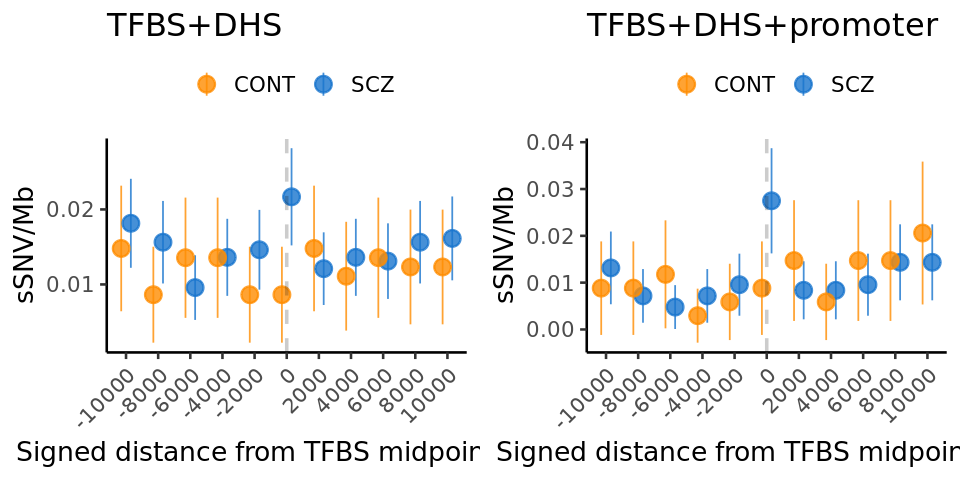

In [7]:
## SCZ vs controls at TFBS

## Get all the TF sites
library(plyranges)
tf_files = system("ls ../../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"


ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)

## Using the generic TF regions and DHS combination

library(genomation)
peak_plot <- function(in_tss=TRUE, t){
    
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),
                    strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)

    dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score,10)
    dhs = dhs[dhs$ntile==10]

    tf_ranges = tf_final
    h = findOverlaps(tf_ranges, tss.gr)
    strand(tf_ranges[queryHits(h)]) = strand(tss.gr[subjectHits(h)])
    if(in_tss){
        tfbs_regions = tf_ranges  %>% filter_by_overlaps(tss.gr) %>% filter_by_overlaps(dhs) 
    } else{
        tfbs_regions = tf_ranges %>% filter_by_overlaps(dhs) 
    }
    tfbs_regions = tfbs_regions %>% reduce_ranges()
    tfbs_regions = resize(tfbs_regions, width=22000,fix="center")

    bin_num = 11
    x = suppressWarnings(ScoreMatrixList(c(SCZ=granges(v_scz),CONT=granges(v_ctrl)), bin.num=bin_num, bin.op = "max", windows=tfbs_regions,
                        strand.aware=TRUE))
    n_dx=60
    n_ctrl = 25
    bin_size = 22000/bin_num
    plot_df = data.frame(SCZ = colMeans(x$SCZ)/(n_dx*bin_size)*10^6, 
                         CONT= colMeans(x$CONT)/(n_ctrl*bin_size)*10^6, 
                        tss_dist = seq(-10000,10000,length.out=bin_num)) 
    scz_counts = colSums(x$SCZ) 
    ctrl_counts = colSums(x$CONT) 
    print(poisson.test(c(as.integer(scz_counts[bin_num %/% 2 + 1L]), as.integer(ctrl_counts[bin_num %/% 2 + 1L])),
                c(n_dx*nrow(x$SCZ)*bin_size,n_ctrl*nrow(x$CONT)*bin_size)))


    p1 = plot_df %>% mutate(tss_dist = factor(as.character(tss_dist),levels=as.character(tss_dist))) %>% 
    mutate(SCZ_sites = n_dx*nrow(x$SCZ)*bin_size, ctrl_sites = n_ctrl*nrow(x$CONT)*bin_size) %>% 
    pivot_longer(SCZ:CONT, names_to = "Dx",values_to = "sSNV_burden") %>%
    mutate(low_ci = ifelse(Dx=="SCZ", sSNV_burden - 1.96*sqrt(sSNV_burden/(SCZ_sites/10^6)), sSNV_burden - 1.96*sqrt(sSNV_burden/(ctrl_sites/10^6)))) %>%
    mutate(high_ci = ifelse(Dx=="SCZ", sSNV_burden + 1.96*sqrt(sSNV_burden/(SCZ_sites/10^6)), sSNV_burden + 1.96*sqrt(sSNV_burden/(ctrl_sites/10^6)))) %>%
    ggplot(aes(x=tss_dist, y=sSNV_burden)) + 
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci, color=Dx), size=1, position=position_dodge(width=0.6), alpha=0.8) +
    theme_classic(16) + labs(color="",x= "Signed distance from TFBS midpoint (bp)",y="sSNV/Mb",title=t) +
    scale_color_manual(values=c("darkorange","dodgerblue3")) +
    geom_vline(xintercept = "0",linetype=2,size=1,alpha=0.2) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1), legend.position = "top") 

    return(p1)
}
    

options(repr.plot.width=8, repr.plot.height=4)
p1 = peak_plot(in_tss=FALSE, t= "TFBS+DHS")
p2 = peak_plot(in_tss=TRUE, t="TFBS+DHS+promoter")
p3 = ggpubr::ggarrange(p1,p2, ncol=2, nrow=1)
p3
# ggsave(p3, filename = "../figures/peak_plots_no_outlier.pdf", device="pdf", width=8, height=4)



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,11280874,602.5,18644165,995.8,18644165,995.8
Vcells,59353243,452.9,270026612,2060.2,337533095,2575.2


Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“1190 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“3201 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“1139 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“3077 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“1106 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“2984 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“1047 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“2820 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“997 windows fall off the target”
Warning mes

,RR,pval,low_ci,high_ci,dhs_cutoff
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
rate ratio,1.152468,0.287191979,0.8906497,1.504054,0.00
rate ratio1,1.168249,0.270695793,0.8941015,1.540783,0.05
rate ratio2,1.155456,0.322546293,0.8806615,1.530554,0.10
rate ratio3,1.134921,0.379035476,0.8593255,1.513812,0.15
rate ratio4,1.106401,0.529121680,0.8315852,1.487159,0.20
rate ratio5,1.073645,0.669275123,0.8041168,1.448220,0.25
rate ratio6,1.089937,0.609082702,0.8092979,1.484140,0.30
rate ratio7,1.089842,0.600647335,0.8030888,1.496249,0.35
rate ratio8,1.145007,0.441749665,0.8339637,1.592817,0.40


Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“333 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“790 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“330 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“783 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“325 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“774 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“318 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“757 windows fall off the target”
Warning message in .local(target, windows, bin.num, bin.op, strand.aware):
“316 windows fall off the target”
Warning message in 

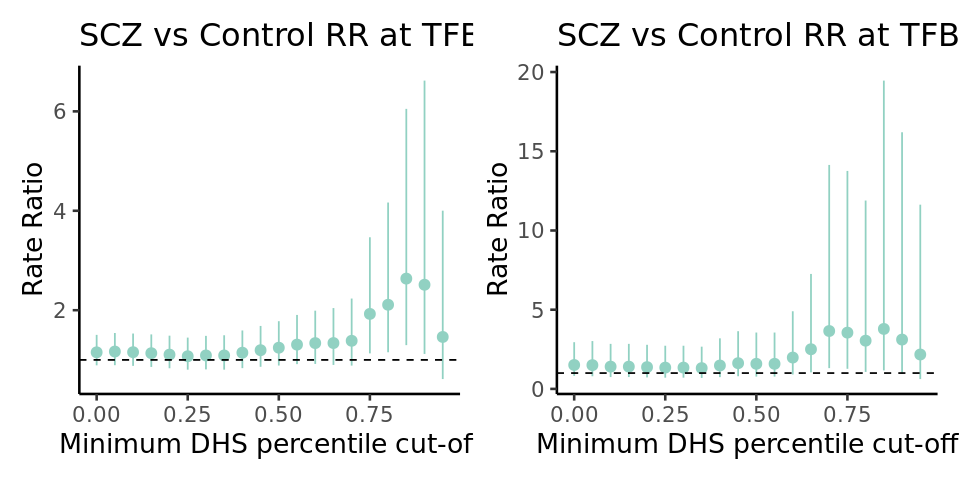

In [8]:
## Using multiple thresholds
gc()
rec_peak_plot <- function(in_tss, t="",dhs_cutoff){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),
                    strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)

    dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs = dhs %>% filter(score >= quantile(score, probs=as.numeric(dhs_cutoff)))

    tf_ranges = tf_final
    h = findOverlaps(tf_ranges, tss.gr)
    strand(tf_ranges[queryHits(h)]) = strand(tss.gr[subjectHits(h)])
    if(in_tss){
        tfbs_regions = tf_ranges  %>% filter_by_overlaps(tss.gr) %>% filter_by_overlaps(dhs) 
    } else{
        tfbs_regions = tf_ranges %>% filter_by_overlaps(dhs) 
    }
    tfbs_regions = tfbs_regions %>% reduce_ranges()
    tfbs_regions = resize(tfbs_regions, width=22000,fix="center")

    bin_num = 11
    x = ScoreMatrixList(c(SCZ=granges(v_scz),CONT=granges(v_ctrl)), bin.num=bin_num, bin.op = "max", windows=tfbs_regions,
                        strand.aware=TRUE)
    n_dx=60
    n_ctrl = 25
    bin_size = 22000/bin_num
    plot_df = data.frame(SCZ = colMeans(x$SCZ)/(n_dx*bin_size)*10^6, 
                         CONT= colMeans(x$CONT)/(n_ctrl*bin_size)*10^6, 
                        tss_dist = seq(-10000,10000,length.out=bin_num)) 
    scz_counts = colSums(x$SCZ) 
    ctrl_counts = colSums(x$CONT) 
    tmp = poisson.test(c(as.integer(scz_counts[bin_num %/% 2 + 1L]), as.integer(ctrl_counts[bin_num %/% 2 + 1L])),
                c(n_dx*nrow(x$SCZ)*bin_size,n_ctrl*nrow(x$CONT)*bin_size))
    pval = tmp$p.value
    cis = tmp$conf.int
    est = tmp$estimate
    res = data.frame(RR = est, pval=pval, low_ci = cis[1],high_ci = cis[2], dhs_cutoff=dhs_cutoff)
    return(res)
}


dhs_ranges = seq(from = 0, to=1, by=0.05)

results_df = lapply(dhs_ranges[1:(length(dhs_ranges)-1)], function(x){
    res = rec_peak_plot(in_tss=FALSE, t="TFBS+DHS+promoter",x)
    return(res)
})

results_df1 = do.call(rbind, results_df)
results_df1 = results_df1 %>% data.frame()
results_df1

options(repr.plot.width=5, repr.plot.height=4)


results_df = lapply(dhs_ranges[1:(length(dhs_ranges)-1)], function(x){
    res = rec_peak_plot(in_tss=TRUE, t="TFBS+DHS",x)
    return(res)
})

results_df2 = do.call(rbind, results_df)
results_df2 = results_df2 %>% data.frame()
options(repr.plot.width=5, repr.plot.height=4)


library(patchwork)
p1=results_df1 %>% ggplot(aes(x= as.numeric(as.character(dhs_ranges[1:(length(dhs_ranges)-1)])), y =RR )) + 
    geom_pointrange(aes(ymin = low_ci, ymax=high_ci),color="#91D1C2FF") +
     theme_classic(16) + 
    geom_hline(yintercept = 1, linetype=2)+
    labs(x="Minimum DHS percentile cut-off", y= "Rate Ratio", size = "Number of\nsSNVin TFBS+DHS+Promoter") +
    theme(legend.position = "bottom") + 
    ggtitle("SCZ vs Control RR at TFBS+DHS+Promoter")

p2=results_df2 %>% ggplot(aes(x= as.numeric(as.character(dhs_ranges[1:(length(dhs_ranges)-1)])), y =RR )) + 
    geom_pointrange(aes(ymin = low_ci, ymax=high_ci),color="#91D1C2FF") +
     theme_classic(16) + 
    geom_hline(yintercept = 1, linetype=2)+
    labs(x="Minimum DHS percentile cut-off", y= "Rate Ratio", size = "Number of\nsSNVin TFBS+DHS") +
    theme(legend.position = "bottom") +
    ggtitle("SCZ vs Control RR at TFBS+DHS")

options(repr.plot.width=8, repr.plot.height=4)
final = p1 +p2
final
# ggsave(filename = "../figures/SCZ_control_TFBS_DHS_multiple_thresholds_no_outlier.pdf",final, device="pdf", width=8, heigh=4)

In [9]:
## SCZ sSNV rate at TFBS

library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")

listMarts(host="https://grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

# transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
#                                   "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
#       filters ="ensembl_gene_id",
#       values  =gene_names$ensembl_gene_id,
#       mart    =mart)


transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),
      mart    =mart)

library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"

## Get all the TF sites
library(plyranges)
tf_files = system("ls ../../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 111
ENSEMBL_MART_SNP,Ensembl Variation 111
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 111


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


[1] 138

In [10]:
library(plyranges)
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)
total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])
total_length

## adapted from https://github.com/Rashesh7/PanBody_manuscript_analyses/blob/main/Signature_Enrichment/Testes_analyses_Signature_and_Enrichment_analyses.Rmd

library(MutationalPatterns)

## Get target vcfs
scz_vcf = granges(v_scz)
ctrl_vcf  = granges(v_ctrl)
genome(ctrl_vcf) = "hg19"
genome(scz_vcf) = "hg19"
target_vcf = scz_vcf

get_triRate <- function(target_vcf, ref_genome = "BSgenome.Hsapiens.UCSC.hg19", surveyed=NULL){
    ## Compute 96 trinuc context and total muts per sample
    muts0 = mut_matrix(target_vcf, ref_genome)

     muts <- as_tibble(muts0) %>% 
          mutate(mutType = rownames(muts0)) %>% 
          rowwise() %>%
          mutate(totMuts = sum(c_across(where(is.numeric)))) %>% 
          mutate(context = paste0(str_sub(mutType,1,1),str_sub(mutType,3,3),str_sub(mutType,7,7))) %>% 
          group_by(context) %>% 
          dplyr::summarise(count = sum(totMuts), .groups = "drop")

    ## Get mean sites per tissue
    if(is.null(surveyed)){
        sequences  = getSeq(BSgenome.Hsapiens.UCSC.hg19)[1:24]
    } else{
        sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19,surveyed)
    }

    ## count trinuc freq
    tri_freqs <- trinucleotideFrequency(sequences)

    #Convert to pyr reference
    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop")
        colnames(tri_freqs_summary) <- c("context", paste0("opps_", "WGS"))
        muts <- muts %>% 
        left_join(tri_freqs_summary, by = "context")

    ## Generate triRateDF
    triRateDF <- tibble()
    freqDF <- muts %>% 
          rowwise() %>%
          mutate(meanOpps = mean(c_across(cols = starts_with("opps_")))) %>% 
          mutate(rate = count/meanOpps) %>% 
#           mutate(rate = rate/sum(lengths(target_vcf))) %>% 
          dplyr::select(context, rate)
    triRateDF <- triRateDF %>% bind_rows(freqDF)
    return(triRateDF)
}


oe_func <- function(target_vcf,region,regionName, triRateTable,
                    surveyed=NULL,ref_genome = "BSgenome.Hsapiens.UCSC.hg19"){
## calculate observed and expected ratio
    n_muts = length(target_vcf)

    if(is.null(surveyed)){
        library(ref_genome, character.only = TRUE)
        total_length = sum(seqlengths(BSgenome.Hsapiens.UCSC.hg19)[1:24])
        surveyed_length = total_length
    } else{
        surveyed_length = sum(as.numeric(width(surveyed)))
    }

    if(is.null(surveyed)){
        surveyed_region = region
    } else{
        surveyed_region = surveyed %>% join_overlap_intersect(region)
    }

    surveyed_region_length = sum(width(surveyed_region))

    # Find which mutations lie in the surveyed genomic region
    muts_in_region = target_vcf %>% filter_by_overlaps(surveyed_region)
    observed = sum(countOverlaps(region, target_vcf))

    #Add base to start and end to get correct trinuc counts
#     surveyed_region@ranges@start <- as.integer(surveyed_region@ranges@start - 1)
#     surveyed_region@ranges@width <- as.integer(surveyed_region@ranges@width + 2)
    
    #Count trinuc freq
    sequences = getSeq(BSgenome.Hsapiens.UCSC.hg19, surveyed_region)
    tri_freqs <- trinucleotideFrequency(sequences)

    complement = vector()
    complement["A"] = "T"; complement["C"] = "G"; complement["G"] = "C"; complement["T"] = "A";	
    tri_freqs_summary <- as_tibble(tri_freqs) %>% 
        dplyr::summarise(across(.cols = everything(), sum)) %>% 
        pivot_longer(cols = everything(), names_to = "context0", values_to = "count") %>% 
        #Convert to pyr reference
        mutate(context = ifelse(str_sub(context0,2,2) %in% c("C", "T"), context0, paste0(complement[str_sub(context0, 3,3)], complement[str_sub(context0, 2,2)], complement[str_sub(context0, 1,1)]))) %>% 
        group_by(context) %>% 
        dplyr::summarise(count = sum(count), .groups = "drop") %>% 
        left_join((triRateTable), by = "context") %>% 
        mutate(expected = count * (rate))

    expected = sum(tri_freqs_summary$expected)
    
    ## calculate CIs
    n_sims = 10000
#     observations = replicate(n_sims, 
#                              sum(countOverlaps(target_vcf[sort(sample(length(target_vcf), size=length(target_vcf), 
#                                                                       replace=TRUE))],surveyed_region)))
#     cis <- quantile(observations, probs = c(0.025, 0.975))
    tmp = poisson.test(c(observed,surveyed_region_length),c(expected, surveyed_region_length))
#     pval = sum(observations/expected <1)/n_sims
    pval = tmp$p.value
    cis = tmp$conf.int
    
    res = data.frame(n_muts,
                surveyed_length,
                regionName,
                surveyed_region_length,
                expected,
                observed,
                     oe = observed/expected,
                    low_ci= cis[1],
                    high_ci = cis[2], pval = pval)
    return(res)

}


[1] 3095677412

Loading required package: NMF

Loading required package: registry

Loading required package: rngtools

Loading required package: cluster

NMF - BioConductor layer [OK] | Shared memory capabilities [NO: bigmemory] | Cores 2/2

  To enable shared memory capabilities, try: install.extras('
NMF
')


Attaching package: ‘NMF’


The following object is masked from ‘package:S4Vectors’:

    nrun




In [11]:
scz_tritable = get_triRate(target_vcf = scz_vcf)

n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,dist_tf
<int>,<dbl>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2236,3095677412,TFBS+DHS+promoter,234890000,235.1343931,183,0.7782783,0.6695982,0.8995723,0.0004795713,5000
2236,3095677412,TFBS+DHS+promoter,40928000,47.5924637,44,0.9245161,0.6717547,1.2411200,0.6635639942,2000
2236,3095677412,TFBS+DHS+promoter,12500000,17.9523187,20,1.1140622,0.6804979,1.7205795,0.6352757290,1000
2236,3095677412,TFBS+DHS+promoter,4510000,8.1662324,10,1.2245549,0.5872213,2.2520022,0.4806821480,500
2236,3095677412,TFBS+DHS+promoter,575400,1.1597586,4,3.4489937,0.9397315,8.8308417,0.0303837546,100
2236,3095677412,TFBS+DHS+promoter,263600,0.5278847,3,5.6830588,1.1719758,16.6084912,0.0165907590,50


n_muts,surveyed_length,regionName,surveyed_region_length,expected,observed,oe,low_ci,high_ci,pval,dist_tf
<int>,<dbl>,<chr>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
2236,3095677412,TFBS+DHS,414380000,380.506771,342,0.8988014,0.8060570,0.9992903,0.0483702758,5000
2236,3095677412,TFBS+DHS,82324000,82.544808,89,1.0782023,0.8658849,1.3268209,0.4739016535,2000
2236,3095677412,TFBS+DHS,26474000,30.300486,34,1.1220942,0.7770827,1.5680146,0.4671978423,1000
2236,3095677412,TFBS+DHS,9795000,13.427117,17,1.2660946,0.7375465,2.0271412,0.3360962567,500
2236,3095677412,TFBS+DHS,1599600,2.505323,8,3.1932005,1.3785949,6.2918933,0.0042999185,100
2236,3095677412,TFBS+DHS,778000,1.219275,7,5.7411171,2.3082191,11.8289519,0.0002761421,50


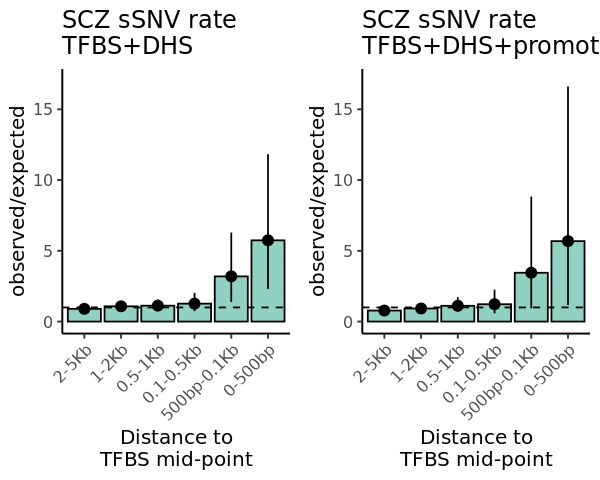

In [12]:
distance_tf = c("5000","2000","1000","500","100","50")
dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
dhs$ntile = ntile(dhs$score,20)
dhs = dhs[dhs$ntile==20]

df = as.data.frame(transcript.gr)
tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                              end=df$transcription_start_site),strand=df$STRAND)

tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)

results_df = parallel::mclapply(distance_tf, function(x){
#     region = resize(tfbs_dhs_promoter, width = 2*as.numeric(x),fix="center")
    region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
    region = region %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) # %>% reduce_ranges()
    res = oe_func(scz_vcf,region = region,regionName = "TFBS+DHS+promoter",triRateTable = scz_tritable)
    return(res)
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% as.data.frame() %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf))

results_promoter = results_df
results_promoter

results_df = parallel::mclapply(distance_tf, function(x){
#     region = resize(tfbs_dhs, width = 2*as.numeric(x),fix="center")
    region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(x), fix="center")
    region = region %>% filter_by_overlaps(dhs) # %>% reduce_ranges()
    res = oe_func(scz_vcf,region = region,regionName = "TFBS+DHS",triRateTable = scz_tritable)
    return(res)
})

results_df = do.call(rbind, results_df)
results_df = results_df %>% as.data.frame() %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf))

results_tfbs_dhs = results_df
results_tfbs_dhs

options(repr.plot.width=3, repr.plot.height=4)
p1 = results_promoter %>%
    ggplot(aes(x=dist_tf,y=oe)) + geom_bar(stat="identity",color="black",fill="#91D1C2FF",alpha=1) + 
    theme_classic(12) + 
    labs(x="Distance to\nTFBS mid-point", y="observed/expected",title=paste("SCZ sSNV rate\nTFBS+DHS+promoter")) +
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci)) + geom_hline(yintercept = 1, linetype=2) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","500bp-0.1Kb","0-500bp")) +
    ylim(0,17)

p2 = results_tfbs_dhs %>%
    ggplot(aes(x=dist_tf,y=oe)) + geom_bar(stat="identity",color="black",fill="#91D1C2FF",alpha=1) + 
    theme_classic(12) + 
    labs(x="Distance to\nTFBS mid-point", y="observed/expected",title=paste("SCZ sSNV rate\nTFBS+DHS")) +
    geom_pointrange(aes(ymin=low_ci, ymax=high_ci)) + geom_hline(yintercept = 1, linetype=2) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","500bp-0.1Kb","0-500bp")) +
    ylim(0,17)

options(repr.plot.width=5, repr.plot.height=4)
p3 = ggpubr::ggarrange(p2,p1)

options(repr.plot.width=5, repr.plot.height=4)
p3
# ggsave(p3,filename = "../../figures/TFBS_dhs_barplots_no_outlier.pdf",device = "pdf",width=5, height=4)

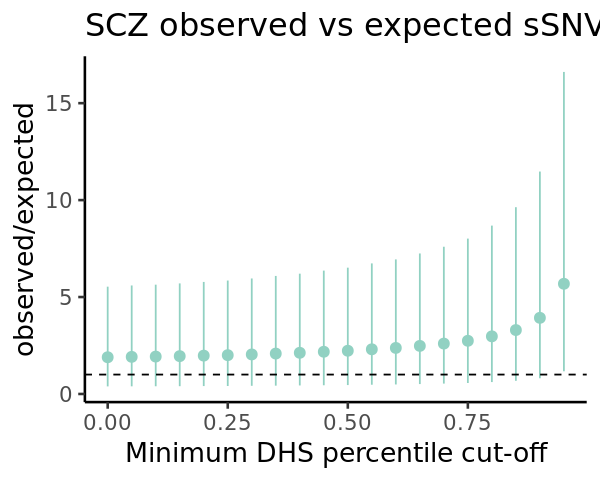

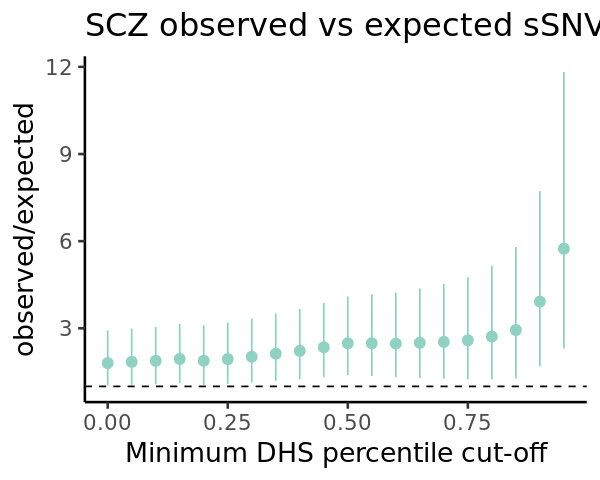

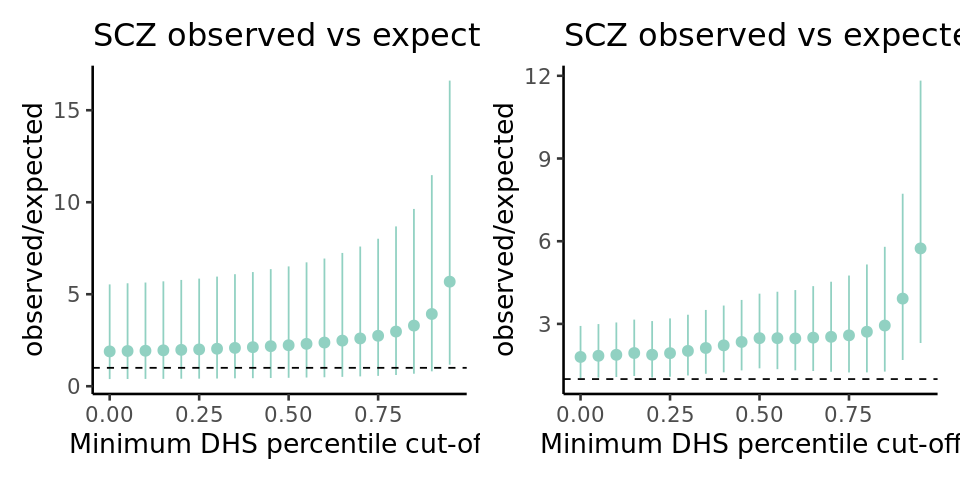

In [13]:
dhs_ranges = seq(from = 0, to=1, by=0.05)


results_df = parallel::mclapply(dhs_ranges[1:(length(dhs_ranges)-1)], function(x){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                          end=df$transcription_start_site),strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs = dhs %>% filter(score >= quantile(score, probs=as.numeric(x)))
#     region=tf_final %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) %>% reduce_ranges()
#     region = resize(region, width = 2*100,fix="center")
    region = resize(tf_final %>% reduce_ranges(), width=2*50, fix="center")
    region = region %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) # %>% reduce_ranges()
    res = oe_func(scz_vcf,region = region,regionName = "TFBS+DHS+promoter",triRateTable = scz_tritable)
    
    return(res)
})

results_df1 = do.call(rbind, results_df)
results_df1 = results_df1 %>% as.data.frame() %>% mutate(dhs_cutoff = dhs_ranges[1:(length(dhs_ranges)-1)])

p1=results_df1 %>% ggplot(aes(x= as.numeric(as.character(dhs_ranges[1:(length(dhs_ranges)-1)])), y =oe )) + 
    geom_pointrange(aes(ymin = low_ci, ymax=high_ci),color="#91D1C2FF") +
     theme_classic(16) + 
    geom_hline(yintercept = 1, linetype=2)+
    labs(x="Minimum DHS percentile cut-off", y= "observed/expected", size = "Number of\nsSNVin TFBS") +
    theme(legend.position = "bottom") + ggtitle("SCZ observed vs expected sSNV rate at TFBS+DHS")
p1


results_df = parallel::mclapply(dhs_ranges[1:(length(dhs_ranges)-1)], function(x){
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                          end=df$transcription_start_site),strand=df$STRAND)
    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    dhs = rtracklayer::import("../../resources//E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs = dhs %>% filter(score >= quantile(score, probs=as.numeric(x)))
#     region=tf_final %>% filter_by_overlaps(dhs) %>% reduce_ranges()
#     region = resize(region, width = 2*100,fix="center")
    region = resize(tf_final %>% reduce_ranges(), width=2*50, fix="center")
    region = region %>% filter_by_overlaps(dhs) # %>% reduce_ranges()
    res = oe_func(scz_vcf,region = region,regionName = "TFBS+DHS",triRateTable = scz_tritable)
    
    return(res)
})

results_df2 = do.call(rbind, results_df)
results_df2 = results_df2 %>% as.data.frame() %>% mutate(dhs_cutoff = dhs_ranges[1:(length(dhs_ranges)-1)])

p2=results_df2 %>% ggplot(aes(x= as.numeric(as.character(dhs_ranges[1:(length(dhs_ranges)-1)])), y =oe )) + 
    geom_pointrange(aes(ymin = low_ci, ymax=high_ci),color="#91D1C2FF") +
     theme_classic(16) + 
    geom_hline(yintercept = 1, linetype=2)+
    labs(x="Minimum DHS percentile cut-off", y= "observed/expected", size = "Number of\nsSNVin TFBS") +
    theme(legend.position = "bottom") + ggtitle("SCZ observed vs expected sSNV rate at TFBS+DHS")
p2

options(repr.plot.width=8, repr.plot.height=4)
pacman::p_load(patchwork)
final = p1 + p2
final
# ggsave(final,filename = "../../figures/TFBS_dhs_barplots_multiple_thresholds_no_outlier.pdf",device = "pdf",width=8, height=4)


Warning message in matrix(as.integer(cols), 3):
“data length [147266] is not a sub-multiple or multiple of the number of rows [3]”
Warning message in color[spec] <- rgb(cols[1, ], cols[2, ], cols[3, ], maxColorValue = 255L):
“number of items to replace is not a multiple of replacement length”
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


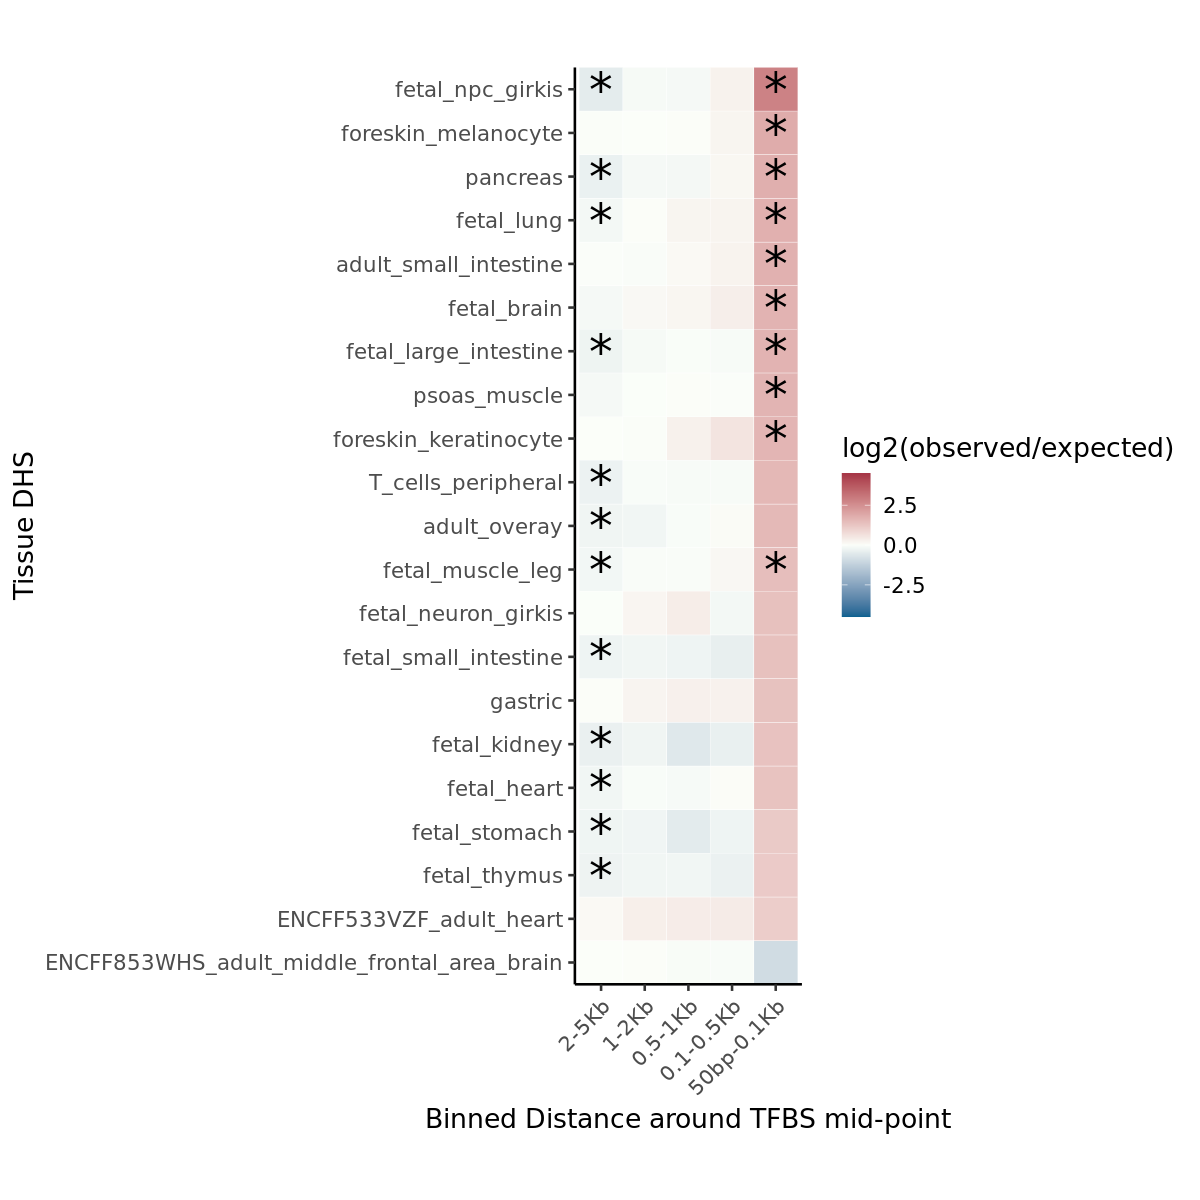

In [14]:
## Tissue DHS analysis

dnase_list = system("ls ../../resources/dnase_files_review/*",intern  =TRUE)
distance_tf = c("5000","2000","1000","500","100")


res = lapply(dnase_list, function(x){
    dhs = rtracklayer::import(x,format = "BED") %>% mutate(ntile=ntile(score,20)) %>% filter(ntile ==20)
#     region = tf_final %>% filter_by_overlaps(dhs)  %>% reduce_ranges()
    results_df = lapply(distance_tf, function(y){
#         region = resize(region, width = 2*as.numeric(y),fix="center")
        region = resize(tf_final %>% reduce_ranges(), width=2*as.numeric(y), fix="center")
        region = region %>% filter_by_overlaps(dhs) # %>% reduce_ranges()
        res = oe_func(scz_vcf,region = region,regionName = "TFBS+DHS+promoter",triRateTable = scz_tritable)
        return(res)
    })
    
    results_df = do.call(rbind, results_df)
    results_df = results_df %>% as.data.frame() %>% mutate(dist_tf = factor(distance_tf, levels=distance_tf))

    results_df$tissue = gsub("../../resources/dnase_files_review/|.bed","",x)
    return(results_df)
})

res = do.call(rbind, res)

tiss_ord = res %>% filter(dist_tf == 100) %>% arrange(oe) %>% pull(tissue)

options(repr.plot.width=10, repr.plot.height=10)
p1 = res %>% mutate(tissue = factor(tissue, levels=tiss_ord), stars = ifelse(p.adjust(pval,"fdr") < 0.05, "*","")) %>% 
    ggplot(aes(x=dist_tf, y=tissue, fil=log2(oe))) + geom_tile(col="white", aes(fill=log2(oe+0.01))) + 
    labs(x="Binned Distance around TFBS mid-point", y= "Tissue DHS",
                                                      fill = "log2(observed/expected)") +
    theme_classic(16) +
    scale_fill_gradient2(mid="#FBFEF9",low="#0C6291",high="#A63446", limits = c(-4.5,4.5)) +
    scale_x_discrete(expand=c(0,0)) +
    scale_y_discrete(expand=c(0,0)) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1,vjust=1)) +
    coord_fixed() +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","50bp-0.1Kb","0-50bp"))+
    geom_text(aes(label=stars), size=10,color="black")
p1 
